In [141]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions
using Alert

In [142]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64,η::Float64,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(sqrt(2*η*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [143]:
U(K::Float64,T::Float64)=[T/sqrt(K^2+T^2),0,K/sqrt(K^2+T^2)] #Es la función que da el eje de rotación dependiente de la curvatura y la torsión
ϕ(K::Float64,T::Float64,Δt::Float64)=Δt*sqrt(K^2+T^2) #Es la función que da el angulo de rotación

ψ0(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar el primer angulo  resultado de dos "matrices/cuaternios"

# Son las funciones para generar el primer eje resultado de dos "matrices/cuaternios"
w1x(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1])*csc(ψ0/2) 
w1y(ϕ0,ϕ1,u,w,ψ0)=((u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
w1z(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3])*csc(ψ0/2)


ψn(ϕ0,ϕ1,u,w)=2*acos(cos(ϕ1/2)*cos(ϕ0/2)-sin(ϕ1/2)*sin(ϕ0/2)*dot(u,w)) # Es la función para generar los otros angulos

# Son las funciones para generar los otros ejes resultado
wnx(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[1]+cos(ϕ0/2)*sin(ϕ1/2)*u[1]-(w[2]*u[3])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)
wny(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[2]+(u[3]*w[1]-w[3]*u[1])*sin(ϕ1/2)*sin(ϕ0/2))*csc(ψ0/2)
wnz(ϕ0,ϕ1,u,w,ψ0)=(cos(ϕ1/2)*sin(ϕ0/2)*w[3]+cos(ϕ0/2)*sin(ϕ1/2)*u[3]+(w[2]*u[1])*sin(ϕ0/2)*sin(ϕ1/2))*csc(ψ0/2)


wnz (generic function with 1 method)

In [144]:
#Acomodamos el eje y el angulo de rotacion en una matriz de euler-rodriguez

MatRot(ω,Ψ)=[ cos(Ψ)+ω[1]^2*(1-cos(Ψ)) ω[1]*ω[2]*(1-cos(Ψ))-ω[3]*sin(Ψ) ω[1]*ω[3]*(1-cos(Ψ))+ω[2]*sin(Ψ);
                ω[2]*ω[1]*(1-cos(Ψ))+ω[3]*sin(Ψ) cos(Ψ)+ω[2]^2*(1-cos(Ψ)) ω[2]*ω[3]*(1-cos(Ψ))-ω[1]*sin(Ψ);
                    ω[3]*ω[1]*(1-cos(Ψ))-ω[2]*sin(Ψ) ω[3]*ω[2]*(1-cos(Ψ))+ω[1]*sin(Ψ) cos(Ψ)+ω[3]^2*(1-cos(Ψ))]

MatRot (generic function with 1 method)

In [145]:
function Trayectoria(Δt::Float64,t::AbstractArray,ω::Array{Array{Float64,1},1},Ψ::Array{Float64,1})

    T_v0=[1.0,0.0,0.0]     #Es el vector tangente inicial
    N_v0=[0.0,1.0,0.0]   #Es el vector tangente inicial
    B_v0=[0.0,0.0,1.0]      #Es el vector tangente inicial
    ##########################################
    T_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    N_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    B_v=Array{Float64,1}[]       #Lista vacia para todos los vectores tangentes
    for i=1:length(t)                 #For que dura todos los pasos de tiempo
        T_v1=MatRot(ω[i],Ψ[i])*T_v0      #Genera todos los vecotres tangentes a partir del inicial
        N_v1=MatRot(ω[i],Ψ[i])*N_v0      #Genera todos los vecotres tangentes a partir del inicial
        B_v1=MatRot(ω[i],Ψ[i])*B_v0      #Genera todos los vecotres tangentes a partir del inicial
        push!(T_v,real(T_v1))    #Coloca los vectores tangentes en una lista
        push!(N_v,real(N_v1))    #Coloca los vectores tangentes en una lista
        push!(B_v,real(B_v1))    #Coloca los vectores tangentes en una lista
    end
    T_v=transpose(hcat(T_v...))     #Transforma T en algo mejor
    N_v=transpose(hcat(N_v...))     #Transforma N en algo mejor
    B_v=transpose(hcat(B_v...))     #Transforma B en algo mejor
    ##########################################
    #Separaos los componentes de la Tangente
    Tx=T_v[:,1]                 
    Ty=T_v[:,2]
    Tz=T_v[:,3]
    ##########################################
    rx=Float64[]   #Abriremos un array para las posiciones
    ry=Float64[]
    rz=Float64[]
    ###################################
    #Posiciones iniciales
    r1x=0.0
    r1y=0.0
    r1z=0.0
    ############
    # Integramos con un for con la suma de Riemman usual
    for i=1:length(t)
        r1x=Tx[i]*Δt+r1x
        r1y=Ty[i]*Δt+r1y
        r1z=Tz[i]*Δt+r1z
        push!(rx,r1x)
        push!(ry,r1y)
        push!(rz,r1z)
    end
    r=[rx,ry,rz]
    T=[Tx,Ty,Tz]
    N=[N_v[:,1],N_v[:,2],N_v[:,3]]
    B=[B_v[:,1],B_v[:,2],B_v[:,3]]
    return r,T,N,B
end



Trayectoria (generic function with 1 method)

In [146]:
function Trayectoria_qua(K::AbstractArray,T::AbstractArray,t::AbstractArray,Δt::Float64)
    Un=U.(K,T)       # Genera todos los ejes "de las matrices R_n"
    ϕn=ϕ.(K,T,Δt)    # Genera todos los ángulos "de las matrices R_n"
    PASO=length(t)   #Todos los pasos

    ω=Array{Array{Float64,1},1}(undef,PASO) #Aquí iran todas los ejes de rotación
    Ψ=Array{Float64,1}(undef,PASO)           #Aquí iran todos los angulos de rotación 
    ω[1]=Un[1]                            # Es el primero que se genera infinitesimalmente
    Ψ[1]=ϕn[1]                            # Es el primero que se genera infinitesimalmente

    ψ1=ψ0(ϕn[1],ϕn[2],Un[1],Un[2])         #Generamos el primer angulo
    w=[w1x(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),     # Generamos el primer eje
        w1y(ϕn[1],ϕn[2],Un[2],Un[1],ψ1),
        w1z(ϕn[1],ϕn[2],Un[2],Un[1],ψ1)];
    ω[2]=w                                  # Lo colocamos en su respectiva lista
    Ψ[2]=ψ1                                 # Lo colocamos en su respectiva lista
    for i=3:PASO                            #como ya generamos los primeros dos ahora generaremos a partir del tercero todos los demas
        ψ=ψn(ψ1,ϕn[i],Un[i],w)           #Generamos un angulo que depende del anterior y del siguiente infinitesimal
        w=[wnx(ψ1,ϕn[i],Un[i],w,ψ),wny(ψ1,ϕn[i],Un[i],w,ψ),wnz(ψ1,ϕn[i],Un[i],w,ψ)] #Generamos un eje que depende del anterior eje y del siguiente infinitesimal
        ω[i]=w  #Agregamos a las listas
        Ψ[i]=ψ1 #Agregamos a las listas
        ψ1=ψ    #Reescribimos
    end
    
    r,Tm,Nm,Bm=Trayectoria(Δt,t,ω,Ψ) #Llamamos a la función trayectoria para que con los angulos y los ejes construya la trayectoria
    
    return r,Tm,Nm,Bm
end

Trayectoria_qua (generic function with 1 method)

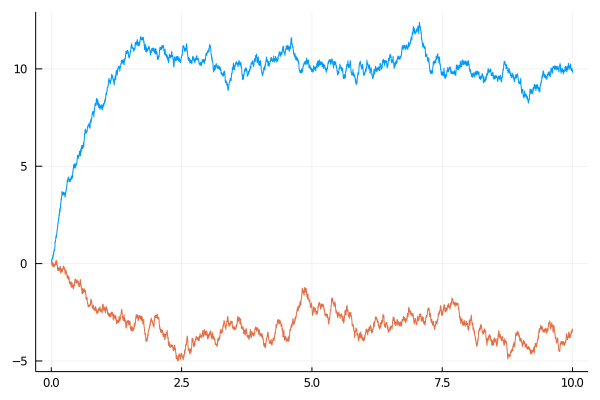

In [150]:
k0=0.1
t0=0.1

γK=2.0
γT=2.0

ηK=1.000
ηT=1.000

N=10.0

Δt=0.001

t=0:Δt:N

ctek=10.0
ctet=-3.0

K=OUH(k0,γK,t,Δt,ηK,ctek)
T=OUH(t0,γT,t,Δt,ηT,ctet)
plot(t,K,legend=false)
plot!(t,T,legend=false)

In [151]:
@time r,Tm,Nm,Bm=Trayectoria_qua(K,T,t,Δt);

  0.051992 seconds (558.68 k allocations: 21.552 MiB, 15.59% gc time)


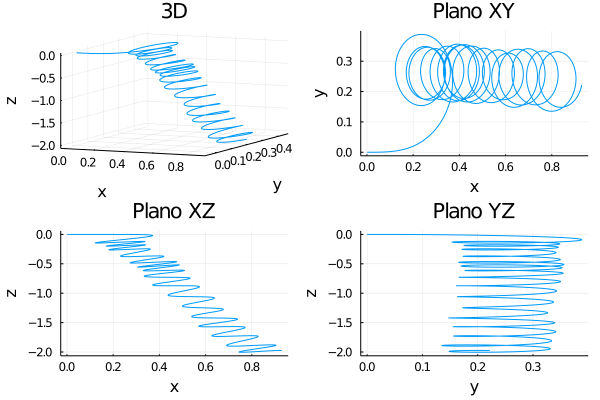

In [152]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(r[1],r[2],r[3], legend=false,title="3D",aspect_ratio=:equal,xlabel="x",ylabel="y",zlabel="z")
P2=plot(r[1],r[2],legend=false,title="Plano XY",xlabel="x",ylabel="y")
P3=plot(r[1],r[3],legend=false,title="Plano XZ",xlabel="x",ylabel="z")
P4=plot(r[2],r[3],legend=false,title="Plano YZ",xlabel="y",ylabel="z")
plot(P1,P2,P3,P4,layout=l)
#savefig("./Trayectorias_3D/Trayectoria_3D_gamK=$(γK)_gam=$(γT)_etaK=$(ηK)_etaT=$(ηT)_k0=$(k0)_t0=$(t0)_ck=_$(ctek)ct=$(ctet).png")

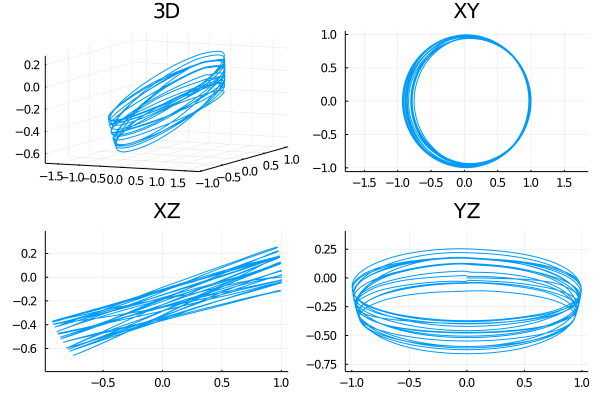

In [153]:
plot(Tm[1],Tm[2],Tm[3], legend=false)
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Tm[1],Tm[2],Tm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Tm[1],Tm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Tm[1],Tm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Tm[2],Tm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l)

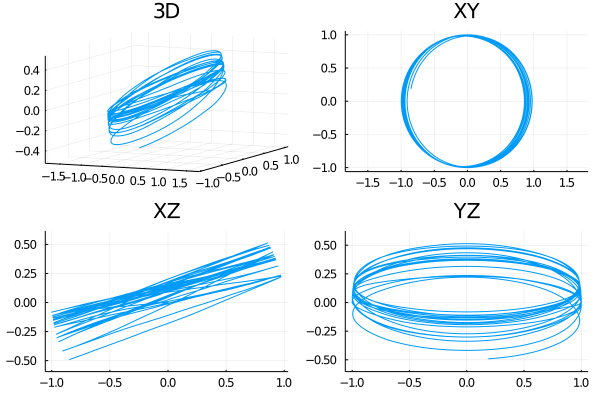

In [154]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Nm[1],Nm[2],Nm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Nm[1],Nm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Nm[1],Nm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Nm[2],Nm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l)


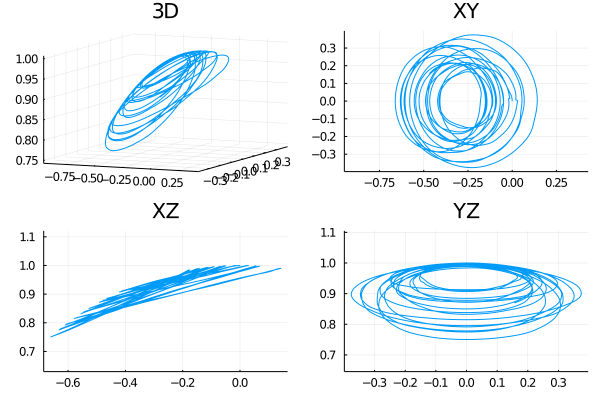

In [155]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Bm[1],Bm[2],Bm[3], legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Bm[1],Bm[2],legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Bm[1],Bm[3],legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Bm[2],Bm[3],legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l)

In [156]:
#W=T*Tm+K*Bm

In [157]:
Wx=Float64[]
Wy=Float64[]
Wz=Float64[]

Wux=Float64[]
Wuy=Float64[]
Wuz=Float64[]
for i=1:length(t)
    wx=Tm[1][i]*T[i]+Bm[1][i]*K[i]
    wy=Tm[2][i]*T[i]+Bm[2][i]*K[i]
    wz=Tm[3][i]*T[i]+Bm[3][i]*K[i]
    push!(Wx,wx)
    push!(Wy,wy)
    push!(Wz,wz)
    
    wux=(Tm[1][i]*T[i]+Bm[1][i]*K[i])/sqrt(K[i]^2+T[i]^2)
    wuy=(Tm[2][i]*T[i]+Bm[2][i]*K[i])/sqrt(K[i]^2+T[i]^2)
    wuz=(Tm[3][i]*T[i]+Bm[3][i]*K[i])/sqrt(K[i]^2+T[i]^2)
    push!(Wux,wux)
    push!(Wuy,wuy)
    push!(Wuz,wuz)

end
W=[Wx,Wy,Wz];


Wu=[Wux,Wuy,Wuz];
step=20
length(1:step:length(t))

501

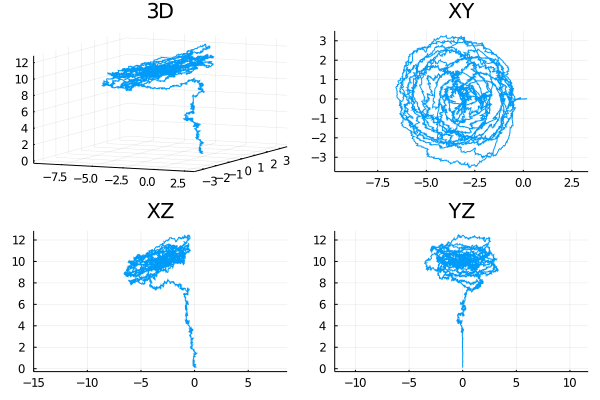

In [158]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Wx,Wy,Wz, legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Wx,Wy,legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Wx,Wz,legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Wy,Wz,legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l)

 25.237704 seconds (21.16 M allocations: 1.016 GiB, 0.56% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\sebas\Desktop\tesis\CODIGOS FINALES\omega_prueba.gif
└ @ Plots C:\Users\sebas\.julia\packages\Plots\SIQaY\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\sebas\\Desktop\\tesis\\CODIGOS FINALES\\omega_prueba.gif")
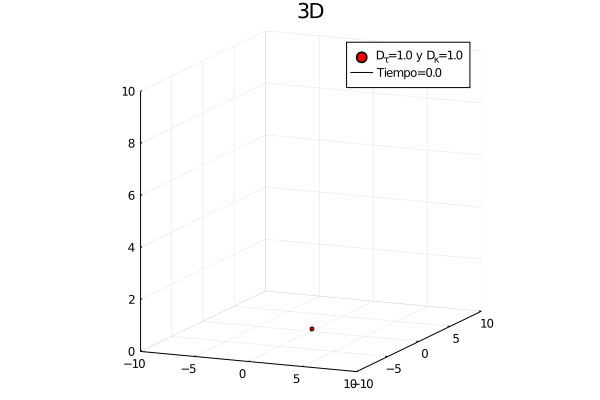

In [159]:
@time begin
    anim= @animate for k=1:step:length(t)
        plot(Wx[1:k],Wy[1:k],Wz[1:k], legend=true,title="3D",aspect_ratio=:equal,xlims=(-10,10),ylims=(-10,10),zlims=(0,10),label="")
        scatter!(Wx[k:k],Wy[k:k],Wz[k:k],color="red",markershape=:circle,markersize=3,label="D_{\\tau}=$(ηT) y D_{\\kappa}=$(ηK)")
        plot!([0,Wx[k]],[0,Wy[k]],[0,Wz[k]],color="black",label="Tiempo=$(t[k])")
    end
    gif(anim,"./omega_prueba.gif", fps=60)
end

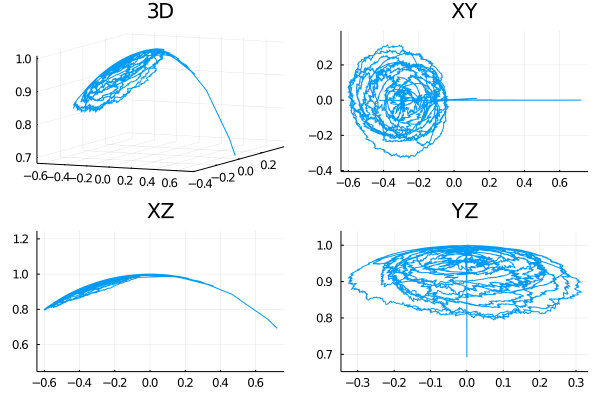

In [160]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
P1=plot(Wux,Wuy,Wuz, legend=false,title="3D",aspect_ratio=:equal)
P2=plot(Wux,Wuy,legend=false,title="XY",aspect_ratio=:equal)
P3=plot(Wux,Wuz,legend=false,title="XZ",aspect_ratio=:equal)
P4=plot(Wuy,Wuz,legend=false,title="YZ",aspect_ratio=:equal)
plot(P1,P2,P3,P4,layout=l)

 24.748373 seconds (21.26 M allocations: 1.012 GiB, 0.53% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\sebas\Desktop\tesis\CODIGOS FINALES\omegau_prueba.gif
└ @ Plots C:\Users\sebas\.julia\packages\Plots\SIQaY\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\sebas\\Desktop\\tesis\\CODIGOS FINALES\\omegau_prueba.gif")
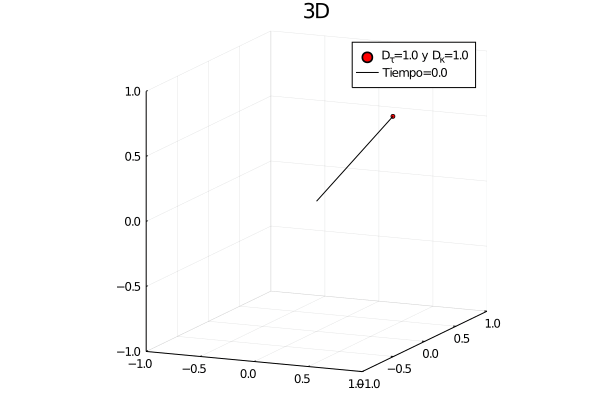

In [161]:
@time begin
    anim= @animate for k=1:step:length(t)
        plot(Wux[1:k],Wuy[1:k],Wuz[1:k], legend=true,title="3D",aspect_ratio=:equal,xlims=(-1,1),ylims=(-1,1),zlims=(-1,1),label="")
        scatter!(Wux[k:k],Wuy[k:k],Wuz[k:k],color="red",markershape=:circle,markersize=3,label="D_{\\tau}=$(ηT) y D_{\\kappa}=$(ηK)")
        plot!([0,Wux[k]],[0,Wuy[k]],[0,Wuz[k]],color="black",label="Tiempo=$(t[k])")
    end
    gif(anim,"./omegau_prueba.gif", fps=60)
end

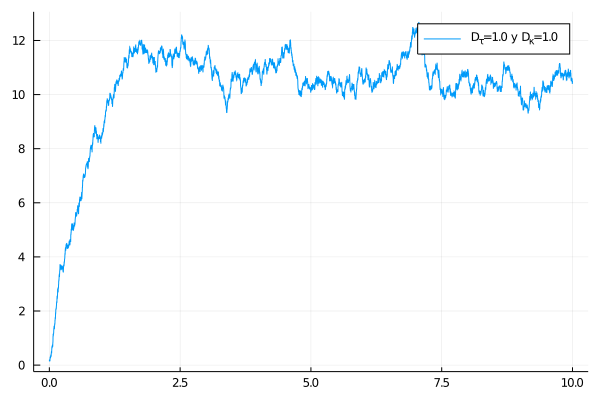

In [162]:
plot(t,sqrt.(Wx.^2+Wy.^2+Wz.^2),label=" D_{\\tau}=$(ηT) y D_{\\kappa}=$(ηK)")

In [163]:
function R(r::Array{Array{Float64,1},1},K::Array{Float64,1},T::Array{Float64,1},N::Array{Array{Float64,1},1})
    Rx=Float64[]
    Ry=Float64[]
    Rz=Float64[]
    for i=1:length(K)
        R1=r[1][i]+N[1][i]*K[i]/(K[i]^2+T[i]^2)
        R2=r[2][i]+N[2][i]*K[i]/(K[i]^2+T[i]^2)
        R3=r[3][i]+N[3][i]*K[i]/(K[i]^2+T[i]^2)
        push!(Rx,R1)
        push!(Ry,R2)
        push!(Rz,R3)
    end
    return [Rx,Ry,Rz]
end

R (generic function with 1 method)

In [164]:
RR=R(r,K,T,Nm);

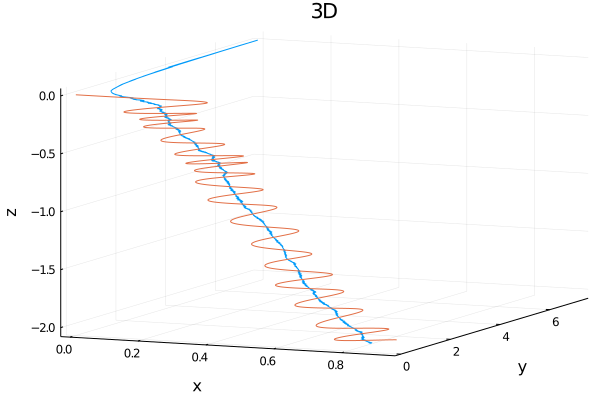

In [165]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
plot(RR[1][1:end],RR[2][1:end],RR[3][1:end], legend=false,title="3D")
plot!(r[1],r[2],r[3], legend=false,title="3D",xlabel="x",ylabel="y",zlabel="z")